# Binary logistic regression (GP classification point estimation) with GD

In [1]:
import sys
sys.path.append("../")


In [2]:
from matplotlib.colors import LinearSegmentedColormap
import functools
from gaussians import *
from sklearn.datasets import make_moons
import jax
from jax import numpy as jnp
from jax import jit
from jax.scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
from matplotlib import ticker
from tueplots import bundles
from tueplots.constants.color import rgb
from tqdm import tqdm

plt.rcParams.update({"figure.dpi": 200})
plt.rcParams.update(bundles.beamer_moml())

colors = [rgb.tue_red, (1, 1, 1), rgb.tue_green]
cmap = LinearSegmentedColormap.from_list("rwg", colors, N=1024)
key = jax.random.PRNGKey(0)

Text(0, 0.5, '$x_2$')

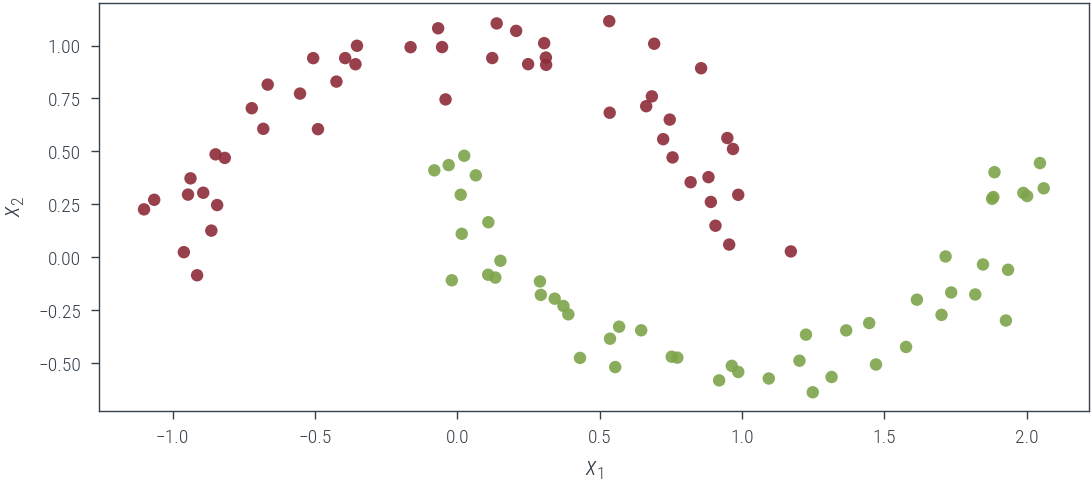

In [3]:
# here's the dataset:
X, y = make_moons(n_samples=100, noise=0.1, random_state=0)
N = X.shape[0]
ysigned = y.copy()
ysigned[y == 0] = -1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, s=20, alpha=0.9, edgecolor="None")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [4]:
# we define a GP prior over the latent function f:
# prior mean and kernel
def constant_mean(x, c=0.0):
    return c * jnp.ones_like(x[:, 0])


def d(x1, x2):
    return jnp.sqrt(jnp.sum((x1 - x2) ** 2, axis=-1))


def Matern_5(x1, x2, l=1.0):
    r = d(x1, x2) / l
    return (1.0 + jnp.sqrt(5) * r + 5.0 / 3.0 * r**2) * jnp.exp(-jnp.sqrt(5) * r)


# link function:
def sigmoid(x):
    return 1.0 / (1.0 + jnp.exp(-x))

For intuition, let's first look at a prior sample

Text(0, 0.5, '$x_2$')

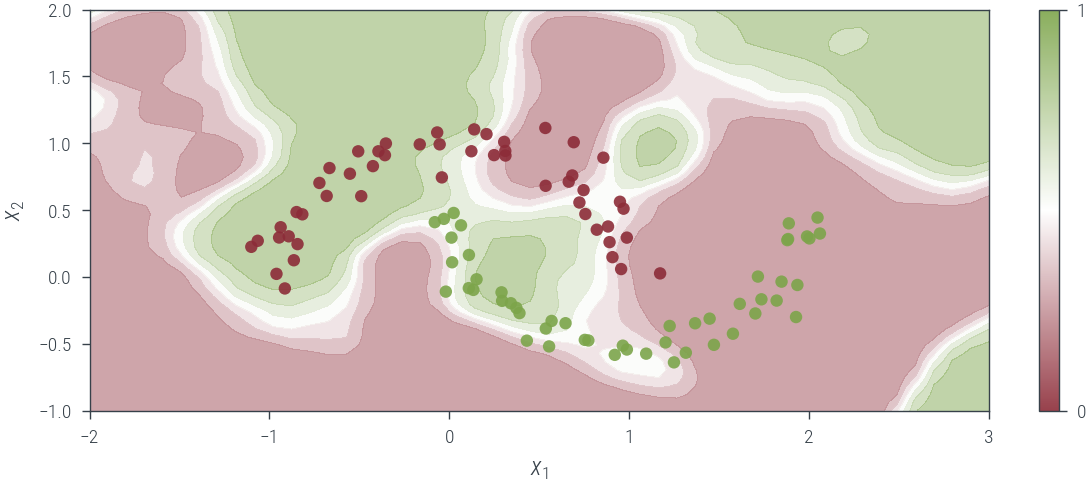

In [5]:
x1 = jnp.linspace(-2, 3, 50)
x2 = jnp.linspace(-1, 2, 50)
X1, X2 = jnp.meshgrid(x1, x2)
X_grid = jnp.stack([X1.flatten(), X2.flatten()], axis=1)

prior = GaussianProcess(lambda x: constant_mean(x,c=0.0), lambda a, b: 5.0**2 * Matern_5(a, b, l=0.7))
sample = prior(X_grid).sample(key=key, num_samples=1)

fig, ax = plt.subplots()
contour = ax.contourf(
    X1, X2, sigmoid(sample).reshape(X1.shape), cmap=cmap, alpha=0.5, vmax=1, vmin=0
)
scatter = ax.scatter(
    X[:, 0], X[:, 1], c=y, cmap=cmap, s=20, alpha=0.9, edgecolor="None"
)
cb = fig.colorbar(ax=ax, mappable=scatter)
cb.set_ticks([0, 1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Now it's time to train. We set up the optimization problem.

In [6]:
# setting up the optimization problem:


def log_likelihood(f, ysigned):
    # p(y|f) = 1 / (1 + exp(-yf)), thus
    # log p(y|f) = 0 - log(exp(0) + exp(-yf))
    return jnp.sum(-jnp.logaddexp(0.0, -ysigned * f))


prior_X = prior(X)  # instantiate once to reuse Cholesky decomposition of covariance


def loss(f):
    f = f.ravel()
    loglikelihood = log_likelihood(f, ysigned)
    logprior = prior_X.log_pdf(f)
    return -(loglikelihood + logprior)

And train with gradient descent:

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 180.86it/s]


Text(0, 0.5, 'loss')

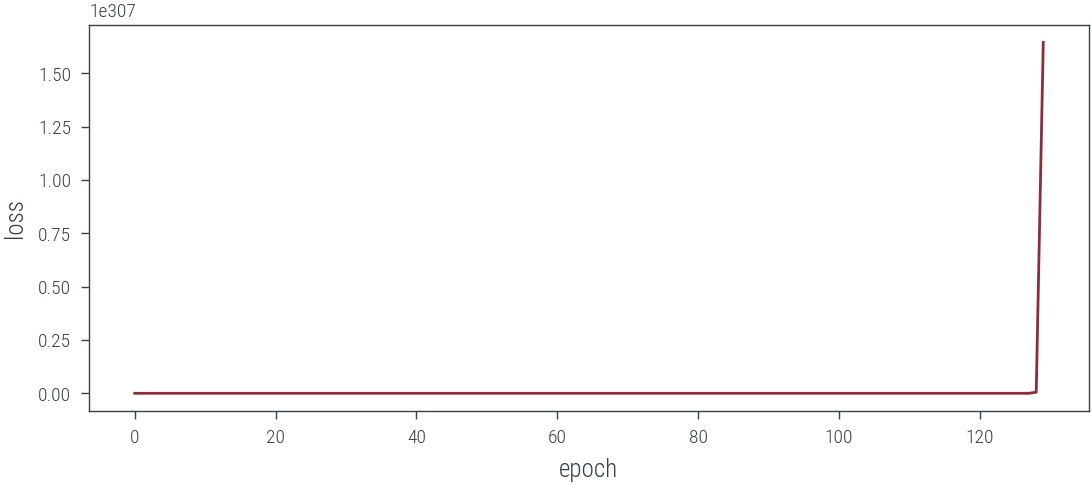

In [14]:
step_size = 1e-3
num_epochs = 1_000

# man, this is slow...
def update(f):
    # we use auto-diff to compute the gradient. This is not necessarily the most efficient way, but convenient.
    L, grad = jax.value_and_grad(loss)(f)
    return (f - step_size * grad, L)


# initialize at zero
f = jnp.zeros(shape=(N,))
losses = []
for epoch in tqdm(range(num_epochs)):
    f, L = update(f)
    losses.append(L)

f_trained = f

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

In [8]:
# for the moment, we only care about the predictive mean.
# we will make use of the matrix B = I + Wsq K Wsq.
# The inverse (K+W^-1)^-1 is then given by Wsq B^-1 Wsq

kXX = prior.k(X[:, None, :], X[None, :, :])
L = cho_factor(kXX, lower=True)


def posterior_mean_function(x):
    kxX = prior.k(x[..., None, :], X[None, :, :])
    return kxX @ cho_solve(L, f_trained)

In [9]:
posterior_x = posterior_mean_function(X_grid)

Text(0, 0.5, '$x_2$')

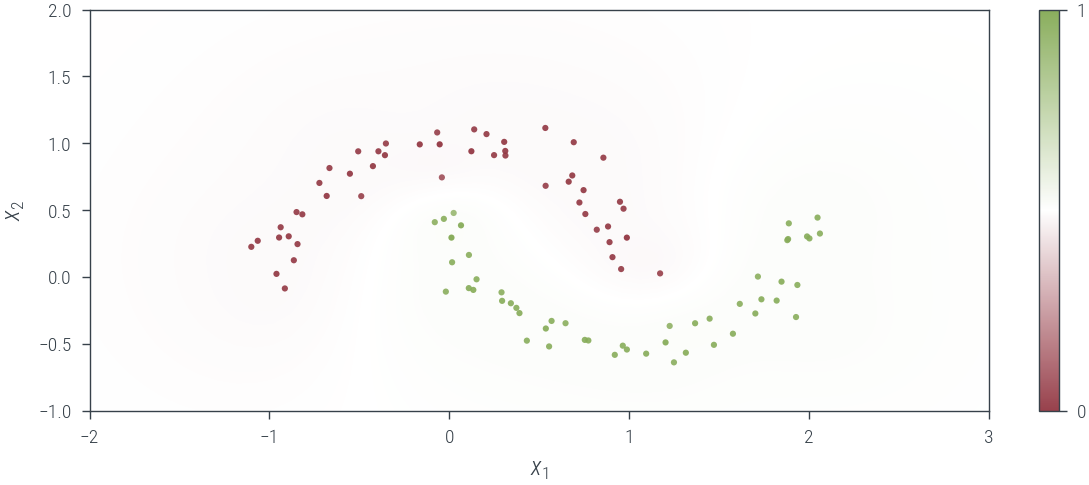

In [10]:
fig, ax = plt.subplots()

contour = ax.contourf(
    X1,
    X2,
    sigmoid(posterior_x).reshape(X1.shape),
    cmap=cmap,
    alpha=1,
    vmax=1,
    vmin=0,
    levels=100,
)
ax.scatter(X[:, 0], X[:, 1], c=sigmoid(f_trained), cmap=cmap, s=5, alpha=0.9, edgecolor="None")

cb = fig.colorbar(ax=ax, mappable=scatter)
cb.set_ticks([0, 1])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")